In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import ray
from ray.experimental.serve.examples.adder import ScalerAdder, VectorizedAdder
from ray.experimental.serve.examples.halt import SleepCounter, SleepOnFirst
from ray.experimental.serve.object_id import unwrap
from ray.experimental.serve.router import DeadlineAwareRouter, start_router
import time

In [2]:
import numpy as np

In [3]:
# We need at least 5 workers so resource won't be oversubscribed
ray.init()

# The following two blobs are equivalent
#
# handle = DeadlineAwareRouter.remote("DefaultTestRouter")
# ray.experimental.register_actor("DefaultTestRouter", handle)
# handle.start.remote()
#
# handle = start_router(DeadlineAwareRouter, "DefaultRouter")
handle = start_router(DeadlineAwareRouter, "DefaultRouter")


2019-03-13 20:22:11,485	WARNING worker.py:1381 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-03-13 20:22:11,487	INFO node.py:423 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-03-13_20-22-11_29443/logs.
2019-03-13 20:22:11,606	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:59133 to respond...
2019-03-13 20:22:11,719	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:44053 to respond...
2019-03-13 20:22:11,721	INFO services.py:760 -- Starting Redis shard with 3.37 GB max memory.
2019-03-13 20:22:11,733	INFO services.py:1384 -- Starting the Plasma object store with 5.05 GB memory using /dev/shm.


In [4]:
handle.register_actor.remote(
    "VAdder", VectorizedAdder,
    init_kwargs={"scaler_increment": 1},
    max_batch_size=1
)

ObjectID(01000000afdf2f0496b0766101b53f9a436fdf1b)

In [5]:
a = handle.call.remote("VAdder", 42, time.perf_counter() + 1)

In [6]:
ray.get(unwrap(a))

43

In [7]:
times = []
result = a
for _ in range(3):
    rt = []
    for i in range(0, 501, 10):
        for j in range(i):
            result = handle.call.remote("VAdder", 42, time.perf_counter() + 1)
        now = time.perf_counter()
        ray.get(unwrap(result))
        after = time.perf_counter()
        rt += [after - now]
        print("# of tasks:", i, "; Latency:", after-now, "ns")
    times += [np.array(rt)]
times = np.array(times)
# times = np.load('latencies.npy')

# of tasks: 0 ; Latency: 0.0036891920026391745 ns
# of tasks: 10 ; Latency: 0.023290604003705084 ns
# of tasks: 20 ; Latency: 0.0461833290028153 ns
# of tasks: 30 ; Latency: 0.07116792000306305 ns
# of tasks: 40 ; Latency: 0.09615870000561699 ns
# of tasks: 50 ; Latency: 0.11191256099846214 ns
# of tasks: 60 ; Latency: 0.1352032720023999 ns
# of tasks: 70 ; Latency: 0.15472221199888736 ns
# of tasks: 80 ; Latency: 0.19135108900081832 ns
# of tasks: 90 ; Latency: 0.20622130199626554 ns
# of tasks: 100 ; Latency: 0.22481173199776094 ns
# of tasks: 110 ; Latency: 0.25745716199162416 ns
# of tasks: 120 ; Latency: 0.28254992300935555 ns
# of tasks: 130 ; Latency: 0.29258303000824526 ns
# of tasks: 140 ; Latency: 0.3197964499995578 ns
# of tasks: 150 ; Latency: 0.36931801700848155 ns
# of tasks: 160 ; Latency: 0.3653103859978728 ns
# of tasks: 170 ; Latency: 0.3796471680107061 ns
# of tasks: 180 ; Latency: 0.41930199999478646 ns
# of tasks: 190 ; Latency: 0.42889939999440685 ns
# of tasks: 2

In [8]:
np.save('latencies.npy', times)
times

array([[3.68919200e-03, 2.32906040e-02, 4.61833290e-02, 7.11679200e-02,
        9.61587000e-02, 1.11912561e-01, 1.35203272e-01, 1.54722212e-01,
        1.91351089e-01, 2.06221302e-01, 2.24811732e-01, 2.57457162e-01,
        2.82549923e-01, 2.92583030e-01, 3.19796450e-01, 3.69318017e-01,
        3.65310386e-01, 3.79647168e-01, 4.19302000e-01, 4.28899400e-01,
        4.74768562e-01, 4.72082444e-01, 5.05589231e-01, 5.14976516e-01,
        5.57619134e-01, 5.76893395e-01, 5.90141112e-01, 6.21555731e-01,
        6.32889122e-01, 6.72187779e-01, 6.93810591e-01, 6.98573960e-01,
        7.25740592e-01, 7.55706441e-01, 7.92908117e-01, 8.07222013e-01,
        8.22535572e-01, 8.32957669e-01, 8.70017205e-01, 9.15074261e-01,
        9.08273345e-01, 9.32933612e-01, 9.59114207e-01, 9.84379212e-01,
        1.00427634e+00, 1.03297283e+00, 1.05336509e+00, 1.08571591e+00,
        1.10034339e+00, 1.12424196e+00, 1.15703947e+00],
       [8.32745005e-04, 2.37835150e-02, 4.78726700e-02, 6.77025190e-02,
       

In [9]:
import matplotlib.pyplot as plt

In [10]:
avg = np.sum(times, axis=0)/np.float(3)
xs = np.array([1] + list(np.arange(10, 501, 10)))

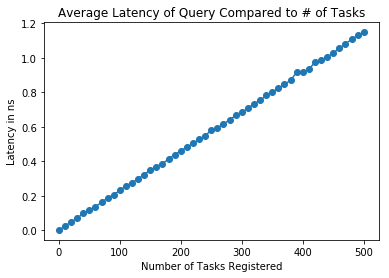

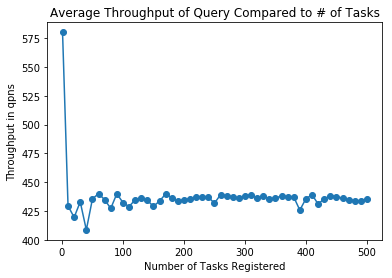

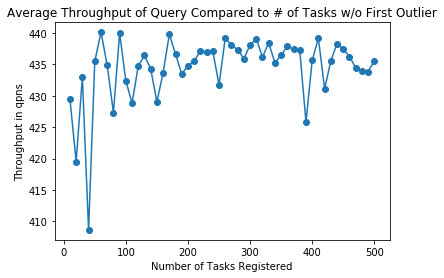

In [11]:
plt.plot(xs, avg, 'o-')
plt.title("Average Latency of Query Compared to # of Tasks")
plt.xlabel("Number of Tasks Registered")
plt.ylabel("Latency in ns");
plt.figure()
plt.plot(xs, xs/avg, 'o-')
plt.title("Average Throughput of Query Compared to # of Tasks")
plt.xlabel("Number of Tasks Registered")
plt.ylabel("Throughput in qpns");
plt.figure()
plt.plot(xs[1:], xs[1:]/avg[1:], 'o-')
plt.title("Average Throughput of Query Compared to # of Tasks w/o First Outlier")
plt.xlabel("Number of Tasks Registered")
plt.ylabel("Throughput in qpns");

In [12]:
times = []
result = a
for _ in range(3):
    rt = []
    for i in range(1, 501, 1):
        result = handle.call.remote("VAdder", 42, time.perf_counter() + 1)
        now = time.perf_counter()
        ray.get(unwrap(result))
        after = time.perf_counter()
        rt += [after - now]
        print("Query ID:", i, "; Latency:", after-now, "ns")
    times += [np.array(rt)]

Query ID: 1 ; Latency: 0.004203321994282305 ns
Query ID: 2 ; Latency: 0.0037033209955552593 ns
Query ID: 3 ; Latency: 0.00292031500430312 ns
Query ID: 4 ; Latency: 0.003708880001795478 ns
Query ID: 5 ; Latency: 0.0031538070034002885 ns
Query ID: 6 ; Latency: 0.0033671409910311922 ns
Query ID: 7 ; Latency: 0.0029878519999329 ns
Query ID: 8 ; Latency: 0.0033919400011654943 ns
Query ID: 9 ; Latency: 0.003087568999035284 ns
Query ID: 10 ; Latency: 0.0029293499974301085 ns
Query ID: 11 ; Latency: 0.0030100209987722337 ns
Query ID: 12 ; Latency: 0.003013818000908941 ns
Query ID: 13 ; Latency: 0.0030302009981824085 ns
Query ID: 14 ; Latency: 0.003158610998070799 ns
Query ID: 15 ; Latency: 0.00338076900516171 ns
Query ID: 16 ; Latency: 0.00355370799661614 ns
Query ID: 17 ; Latency: 0.0033346460113534704 ns
Query ID: 18 ; Latency: 0.0038108940061647445 ns
Query ID: 19 ; Latency: 0.003479956998489797 ns
Query ID: 20 ; Latency: 0.003604947996791452 ns
Query ID: 21 ; Latency: 0.003714952996233478 

Query ID: 208 ; Latency: 0.0030511590011883527 ns
Query ID: 209 ; Latency: 0.0031375100079458207 ns
Query ID: 210 ; Latency: 0.0034543419897090644 ns
Query ID: 211 ; Latency: 0.003421428002184257 ns
Query ID: 212 ; Latency: 0.0031366600014735013 ns
Query ID: 213 ; Latency: 0.0038636879908153787 ns
Query ID: 214 ; Latency: 0.003609335995861329 ns
Query ID: 215 ; Latency: 0.004653773998143151 ns
Query ID: 216 ; Latency: 0.0028619799995794892 ns
Query ID: 217 ; Latency: 0.003293775997008197 ns
Query ID: 218 ; Latency: 0.0027677839971147478 ns
Query ID: 219 ; Latency: 0.0032155079970834777 ns
Query ID: 220 ; Latency: 0.00343357800738886 ns
Query ID: 221 ; Latency: 0.0036439999967115 ns
Query ID: 222 ; Latency: 0.0034465599892428145 ns
Query ID: 223 ; Latency: 0.0030053580121602863 ns
Query ID: 224 ; Latency: 0.0030337709904415533 ns
Query ID: 225 ; Latency: 0.003328988008433953 ns
Query ID: 226 ; Latency: 0.0035308119986439124 ns
Query ID: 227 ; Latency: 0.0037747109890915453 ns
Query ID: 

Query ID: 415 ; Latency: 0.0037669519952032715 ns
Query ID: 416 ; Latency: 0.003633287997217849 ns
Query ID: 417 ; Latency: 0.003435380000155419 ns
Query ID: 418 ; Latency: 0.0030139279988361523 ns
Query ID: 419 ; Latency: 0.0037690769968321547 ns
Query ID: 420 ; Latency: 0.0029717979923589155 ns
Query ID: 421 ; Latency: 0.002808461998938583 ns
Query ID: 422 ; Latency: 0.0035643359879031777 ns
Query ID: 423 ; Latency: 0.003352676998474635 ns
Query ID: 424 ; Latency: 0.0035264239995740354 ns
Query ID: 425 ; Latency: 0.003036281996173784 ns
Query ID: 426 ; Latency: 0.003348072001244873 ns
Query ID: 427 ; Latency: 0.0032345429935958236 ns
Query ID: 428 ; Latency: 0.0033163040061481297 ns
Query ID: 429 ; Latency: 0.0031591930019203573 ns
Query ID: 430 ; Latency: 0.0031825439946260303 ns
Query ID: 431 ; Latency: 0.0030470119963865727 ns
Query ID: 432 ; Latency: 0.003083864998188801 ns
Query ID: 433 ; Latency: 0.0036517469998216256 ns
Query ID: 434 ; Latency: 0.0034631960006663576 ns
Query I

Query ID: 124 ; Latency: 0.0035723350010812283 ns
Query ID: 125 ; Latency: 0.002765115990769118 ns
Query ID: 126 ; Latency: 0.003571694003767334 ns
Query ID: 127 ; Latency: 0.0031582340016029775 ns
Query ID: 128 ; Latency: 0.0033935209939954802 ns
Query ID: 129 ; Latency: 0.0031067809904925525 ns
Query ID: 130 ; Latency: 0.002654302996234037 ns
Query ID: 131 ; Latency: 0.002903314001741819 ns
Query ID: 132 ; Latency: 0.003552987996954471 ns
Query ID: 133 ; Latency: 0.0032529399904888123 ns
Query ID: 134 ; Latency: 0.0032609100016998127 ns
Query ID: 135 ; Latency: 0.002979051001602784 ns
Query ID: 136 ; Latency: 0.0028569909918587655 ns
Query ID: 137 ; Latency: 0.00305497799126897 ns
Query ID: 138 ; Latency: 0.0036210669932188466 ns
Query ID: 139 ; Latency: 0.003377385000931099 ns
Query ID: 140 ; Latency: 0.002924602013081312 ns
Query ID: 141 ; Latency: 0.003266400992288254 ns
Query ID: 142 ; Latency: 0.003697715001180768 ns
Query ID: 143 ; Latency: 0.0033089889911934733 ns
Query ID: 14

Query ID: 332 ; Latency: 0.003453699013334699 ns
Query ID: 333 ; Latency: 0.004493559987167828 ns
Query ID: 334 ; Latency: 0.0033879939874168485 ns
Query ID: 335 ; Latency: 0.0029226710030343384 ns
Query ID: 336 ; Latency: 0.0032993140048347414 ns
Query ID: 337 ; Latency: 0.0030369589949259534 ns
Query ID: 338 ; Latency: 0.003601365999202244 ns
Query ID: 339 ; Latency: 0.0033165860077133402 ns
Query ID: 340 ; Latency: 0.0035358049935894087 ns
Query ID: 341 ; Latency: 0.0031748570036143064 ns
Query ID: 342 ; Latency: 0.003462077002041042 ns
Query ID: 343 ; Latency: 0.003842107005766593 ns
Query ID: 344 ; Latency: 0.003047010992304422 ns
Query ID: 345 ; Latency: 0.0035062840033788234 ns
Query ID: 346 ; Latency: 0.002951054004370235 ns
Query ID: 347 ; Latency: 0.003119001994491555 ns
Query ID: 348 ; Latency: 0.0031347690091934055 ns
Query ID: 349 ; Latency: 0.003638667010818608 ns
Query ID: 350 ; Latency: 0.003417861007619649 ns
Query ID: 351 ; Latency: 0.0030395249923458323 ns
Query ID: 

Query ID: 39 ; Latency: 0.004942297993693501 ns
Query ID: 40 ; Latency: 0.0036309230054030195 ns
Query ID: 41 ; Latency: 0.003223309002351016 ns
Query ID: 42 ; Latency: 0.002870587006327696 ns
Query ID: 43 ; Latency: 0.0030727139965165406 ns
Query ID: 44 ; Latency: 0.0034708090097410604 ns
Query ID: 45 ; Latency: 0.002940453006885946 ns
Query ID: 46 ; Latency: 0.0030991590028861538 ns
Query ID: 47 ; Latency: 0.0035120829998049885 ns
Query ID: 48 ; Latency: 0.0027297959895804524 ns
Query ID: 49 ; Latency: 0.003155644008074887 ns
Query ID: 50 ; Latency: 0.0036334750038804486 ns
Query ID: 51 ; Latency: 0.002947023996966891 ns
Query ID: 52 ; Latency: 0.003069639002205804 ns
Query ID: 53 ; Latency: 0.003053811000427231 ns
Query ID: 54 ; Latency: 0.002873163000913337 ns
Query ID: 55 ; Latency: 0.0030236330057960004 ns
Query ID: 56 ; Latency: 0.003670554986456409 ns
Query ID: 57 ; Latency: 0.003635885994299315 ns
Query ID: 58 ; Latency: 0.0035473659954732284 ns
Query ID: 59 ; Latency: 0.00328

Query ID: 247 ; Latency: 0.0034837249986594543 ns
Query ID: 248 ; Latency: 0.003479014994809404 ns
Query ID: 249 ; Latency: 0.0034364450111752376 ns
Query ID: 250 ; Latency: 0.003105145995505154 ns
Query ID: 251 ; Latency: 0.0032105380087159574 ns
Query ID: 252 ; Latency: 0.003364771997439675 ns
Query ID: 253 ; Latency: 0.0031932050042087212 ns
Query ID: 254 ; Latency: 0.003812791997916065 ns
Query ID: 255 ; Latency: 0.0030867710011079907 ns
Query ID: 256 ; Latency: 0.0034960789926117286 ns
Query ID: 257 ; Latency: 0.0031613870087312534 ns
Query ID: 258 ; Latency: 0.0036709429987240583 ns
Query ID: 259 ; Latency: 0.0031653829937567934 ns
Query ID: 260 ; Latency: 0.0035469780123094097 ns
Query ID: 261 ; Latency: 0.0036865639995085075 ns
Query ID: 262 ; Latency: 0.0035262610035715625 ns
Query ID: 263 ; Latency: 0.0033609990059630945 ns
Query ID: 264 ; Latency: 0.0030027350003365427 ns
Query ID: 265 ; Latency: 0.0029577610112028196 ns
Query ID: 266 ; Latency: 0.003233643001294695 ns
Query

Query ID: 457 ; Latency: 0.003160954001941718 ns
Query ID: 458 ; Latency: 0.0029372370045166463 ns
Query ID: 459 ; Latency: 0.003005817998200655 ns
Query ID: 460 ; Latency: 0.002896249992772937 ns
Query ID: 461 ; Latency: 0.002912379990448244 ns
Query ID: 462 ; Latency: 0.0031237920047715306 ns
Query ID: 463 ; Latency: 0.003472680997219868 ns
Query ID: 464 ; Latency: 0.002799611000227742 ns
Query ID: 465 ; Latency: 0.003253096991102211 ns
Query ID: 466 ; Latency: 0.0032836479949764907 ns
Query ID: 467 ; Latency: 0.0033593530097277835 ns
Query ID: 468 ; Latency: 0.002918523008702323 ns
Query ID: 469 ; Latency: 0.0034291359916096553 ns
Query ID: 470 ; Latency: 0.0030628340027760714 ns
Query ID: 471 ; Latency: 0.003647573001217097 ns
Query ID: 472 ; Latency: 0.003536681004334241 ns
Query ID: 473 ; Latency: 0.0034316329983994365 ns
Query ID: 474 ; Latency: 0.0035873760061804205 ns
Query ID: 475 ; Latency: 0.002986633000546135 ns
Query ID: 476 ; Latency: 0.0034048270026687533 ns
Query ID: 4

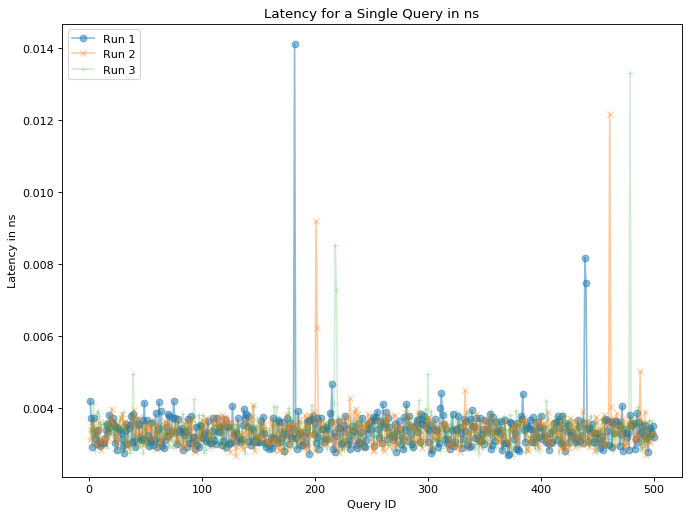

In [31]:
times = np.load('latencysq.npy')
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 7.5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.arange(1, 501, 1), times[0], 'o-', label='Run 1', alpha=0.5)
plt.plot(np.arange(1, 501, 1), times[1], 'x-', label='Run 2', alpha=0.4)
plt.plot(np.arange(1, 501, 1), times[2], '+-', label='Run 3', alpha=0.2)
plt.legend()
plt.title("Latency for a Single Query in ns")
plt.xlabel("Query ID")
plt.ylabel("Latency in ns");

In [14]:
np.save('latencysq.npy', times)

In [15]:
reps = []
for i in range(1,4):
    handle.set_replica.remote("VAdder", i)
    total = 0.0
    for _ in range(3):
        for i in range(0, 1001, 10):
            result = handle.call.remote("VAdder", 42, time.perf_counter() + 1)
        now = time.perf_counter()
        ray.get(unwrap(result))
        after = time.perf_counter()
        total += (after - now)
    total /= 3.0
    reps += [total]
reps = np.array(reps)
reps

array([0.23334321, 0.22930121, 0.23311309])

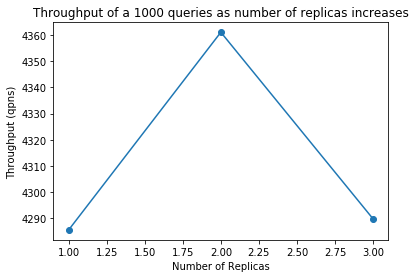

In [21]:
nxs = np.arange(1,4)
plt.plot(nxs, 1000/reps, "o-")
plt.title("Throughput of a 1000 queries as number of replicas increases")
plt.xlabel("Number of Replicas")
plt.ylabel("Throughput (qpns)");